# Simulate acoustic wave propagation of a line array source

The OptimUS library provides functionality to simulate acoustic wave propagation in unbounded domains with homogeneous scatterers. This notebook demonstrates a simulation with a line array transducer with 7 elements.

## Import the OptimUS library

Load the OptimUS library.

In [1]:
import sys
sys.path.append('..')
import optimus

## Specify a spherical section array transducer as acoustic source

The OptimUS library provides different predefined wave fields, among which is a planar array transducer radiating in 2*pi space. The array requires the frequency, element centroid locations, element radius and velocity, optionally, the source axis, and its location. The elements are assumed to be planar circular piston sources. Here, uniform normal velocity of 0.1 m/s is applied to all elements of the array and the source axis is set to be along the z-axis, i.e. identified by the vector [0,0,1].

The centroids of an example transducer array are stored in a text file available in the `./Data` subfolder. Alternatively, one can use a custom defined transducer array.

In [2]:
frequency = 1000
a = 0.1524
centroid_file='./Data/default_line_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[0, 0, -2], array_type="planar",
                                     number_of_point_sources_per_wavelength=16,
                                     velocity=0.1,
                                     source_axis=(0, 0, 1),)

## Specify the physical settings for the simulation

Let us consider a spherical object with unit radius that resembles bone and is embedded in an unbounded region of water.

In [3]:
sphere_radius = 1.0
geometry = optimus.geometry.shapes.Sphere(radius=sphere_radius, element_size=0.25)
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')

## Visualise the incident wave field

Before performing the acoustic simulation, let us inspect the transducer array and visualise the incident wave field. The location of the centroids of the transducers in the array can be retrieved from the source object and plotted in Matplotlib. The focal point at the global origin is visualised by the red marker.

<IPython.core.display.Javascript object>


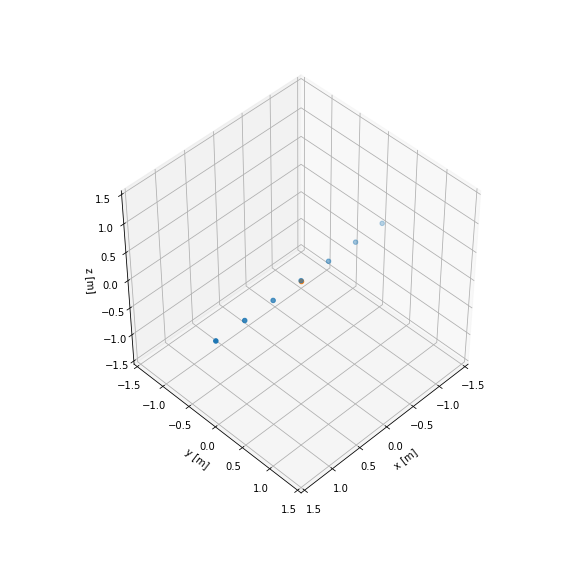

In [13]:
%matplotlib nbAgg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.scatter(x, y, z)
ax.scatter(0, 0, 0, 'r')
ax.set_aspect('equal')
ax.view_init(45, 45)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")
ax.set_xlim(x.min(), x.max()) 
ax.set_ylim(x.min(), x.max())
ax.set_zlim(x.min(), x.max())
plt.show()

Let us define a plane on which to evaluate the incident wave field.

In [5]:
import numpy as np
Nx = 200
Nz = 200
xmin, xmax, zmin, zmax = [-3.0, 3.0, -2.0, 3.0]
yval = 0.0
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, zmin:zmax:Nz * 1j]
points = np.vstack((plot_grid[0].ravel(),                    
                    yval*np.ones(plot_grid[0].size),
                    plot_grid[1].ravel()))

Let us calculate the incident wave field on the points. This can be computationally expensive, depending on the size of the transducer array and the visualisation grid.

In [6]:
from optimus.source.transducers import transducer_field
inc_field = transducer_field(source, material_ext, points, verbose=True)
incident_pressure = inc_field.pressure.reshape([Nx, Nz])

Number of point sources across element diameter: 4
Number of point sources in transducer: 28
Parallelisation library is: numba


Let us visualise the incident pressure field.

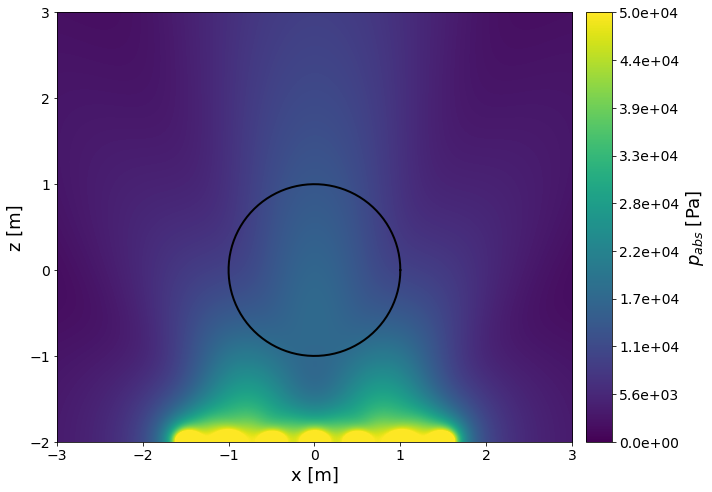

In [7]:
%matplotlib inline
from optimus.postprocess.plot import surface_plot

incident_pressure_plot = optimus.postprocess.common.array_to_imshow(incident_pressure)

theta = np.linspace(0, 2*np.pi, 100)
edge_sphere = (geometry.origin[0] + geometry.radius * np.cos(theta),
               geometry.origin[1] + geometry.radius * np.sin(theta))

fig = surface_plot(np.abs(incident_pressure_plot),
                   axes_lims=(xmin, xmax, zmin, zmax),
                   axes_labels=("x [m]", "z [m]"),
                   colormap='viridis',
                   colormap_lims=[0,50e3],
                   colorbar_unit="$p_{abs}$ [Pa]",
                   domains_edges=[edge_sphere],
                   )

## Simulate the wave model

The OptimUS library uses the Boundary Element Method to simulate acoustic wave propagation. Let us use a model with default settings.

In [8]:
model = optimus.model.create_default_model(source, geometry, material_ext, material_int)

After creating the model, it needs to be solved to obtain the surface potentials at the material interface. Depending on the size of the model, this can be computationally expensive. The solution will be stored inside the model object.

In [9]:
model.solve()

## Visualisation of the acoustic field

The acoustic field can be calculated in arbitrary points. Let us visualize the field on a grid in the plane $y=0$.

In [10]:
postprocess_plane = optimus.postprocess.VisualisePlane(model)
postprocess_plane.create_computational_grid(resolution=(200, 200), 
                                            bounding_box=(xmin, xmax, zmin, zmax), 
                                            plane_axes=(0,2))
postprocess_plane.compute_fields()

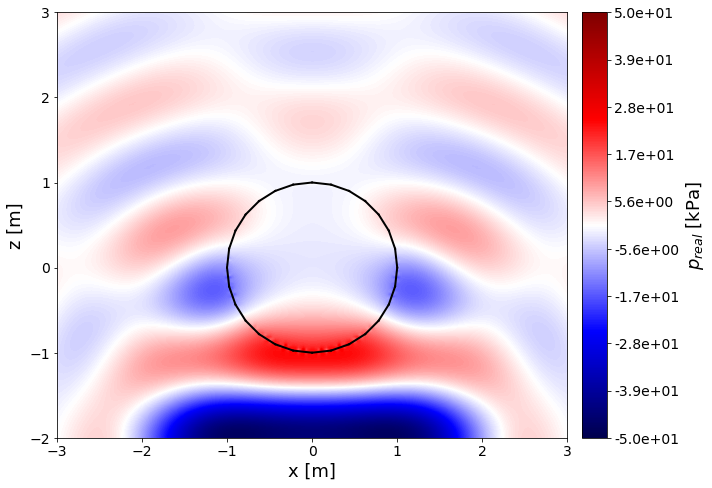

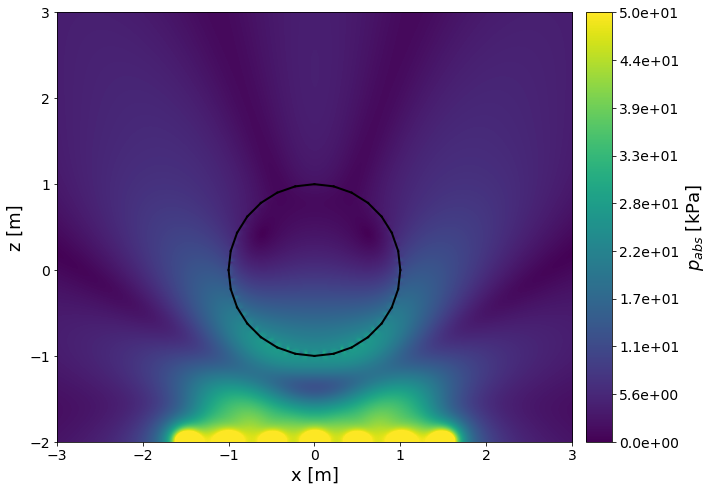

In [11]:
%matplotlib inline
figs = optimus.postprocess.plot_pressure_field(postprocess_plane, field="total", clim=(-50, 50), unit="kPa")